# (??) Fit neurons (MT)

**Motivation**: Load models, evaluate then fit MT <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from analysis.opticflow import *
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
vae = VAE(ConfigVAE(
    n_kers=4,
    n_latent_scales=2, n_groups_per_scale=20, n_latent_per_group=7,
    scale_init=False, residual_kl=True, ada_groups=True,
))
tr = TrainerVAE(model=vae, cfg=ConfigTrainVAE(batch_size=500), device='cuda:1')
vae.cfg.total_latents()

n_ftrs_enc, n_ftrs_dec = vae.ftr_sizes()

In [3]:
from readout.readout import ReadoutSep, Readout3D, ConfigReadout

cfg = ConfigReadout(n_ftrs_enc)
readout = ReadoutSep(cfg).to(tr.device)

print(readout)
readout.print()

ReadoutSep(
  (downsample): ModuleDict(
    (8): Upsample(size=4, mode='nearest')
  )
  (act_ftr): SiLU()
  (criterion): PoissonNLLLoss()
  (dropout): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=5312, out_features=1, bias=True)
  (tker): Conv1D(1, 1, kernel_size=(21,), stride=(1,), padding=(20,))
  (sker): Linear(in_features=16, out_features=1, bias=True)
)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  ReadoutSep |   5.3 K    |
|     ---     |    ---     |
|      fc     |   5.3 K    |
|     tker    |     23     |
|     sker    |     18     |
+-------------+------------+

In [4]:
y = readout._op(tr.to(torch.randn(500, 113, 4, 4)), readout.sker)
y.size()

torch.Size([500, 113])

In [5]:
x, _ = next(iter(tr.dl_trn))
*_, ftr = vae.xtract_ftr(x, full=True)

In [6]:
y = readout(ftr['enc'])
y.size()

torch.Size([500, 1])

In [16]:
ftr_proc = process_ftrs(ftr['enc'], 16)
{k: x.size() for k, x in ftr_proc.items()}

{8: torch.Size([500, 2624, 8, 8]), 4: torch.Size([500, 2688, 4, 4])}

(21,)

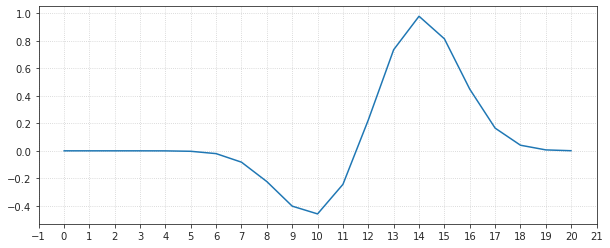

In [4]:
x = np.linspace(0, 20, 21)
y1 = np.exp(-(x - 14)**2 / 5)
y2 = -0.5 * np.exp(-(x - 10)**2 / 5)
y = y1 + y2
tker = torch.Tensor(y).unsqueeze(0).unsqueeze(0)

fig, ax = create_figure(figsize=(10, 4))
ax.plot(y)
ax.locator_params(axis='x', nbins=24)
ax.grid();

y.shape

In [5]:
x = np.zeros(1000)
x[700:721] = y
x = torch.tensor(x, dtype=torch.float)
x.size()

torch.Size([1000])

(1020,)

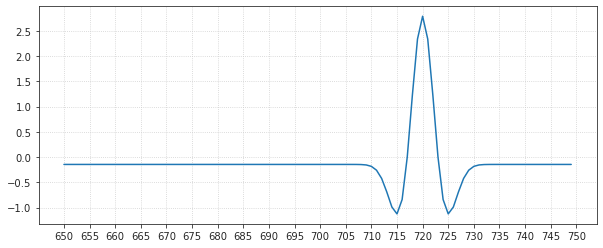

In [6]:
c = nn.Conv1d(1, 1, len(y), padding=len(y) - 1)
c.weight.data = tker

out = c(x.view(1, 1, -1))
out = to_np(out.squeeze())

fig, ax = create_figure(figsize=(10, 4))

intvl = range(650, 750)# range(690, 710)
ax.plot(intvl, out[intvl])
ax.locator_params(axis='x', nbins=25)
ax.grid();

out.shape

(3, 1000)

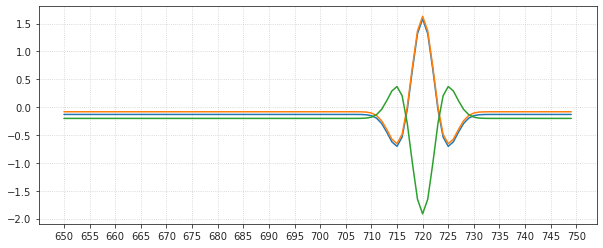

In [7]:
c = Conv1D(1, 3, len(y))
c.weight.data[[0]] = 1 * tker
c.weight.data[[1]] = 15 * tker
c.weight.data[[2]] = -2 * tker

out = c(x.view(1, 1, -1))
out = to_np(out[0])

intvl = range(650, 750)
fig, ax = create_figure(figsize=(10, 4))
for i in range(3):
    ax.plot(intvl, out[i, intvl], color=f'C{i}')
ax.locator_params(axis='x', nbins=25)
ax.grid();

out.shape

In [8]:
out = c(x.view(1, 1, -1))
out.shape

torch.Size([1, 3, 1000])

In [8]:
c.lognorm

Parameter containing:
tensor([0., 0., 0.], requires_grad=True)

In [9]:
out = c(x.view(1, 1, -1))
out.size()

torch.Size([1, 3, 1000])

In [10]:
c.weight.size()

torch.Size([3, 1, 21])

In [11]:
c.dims, c.shape

([1, 2], [-1, 1, 1])

## Load neuron

In [2]:
from common.dataset import setup_supervised_data, setup_repeat_data, time_embed

cfg = ConfigVAE(save=False)
file = h5py.File(cfg.h_file, 'r')
expt = 'clu090'
grp = file[expt]

In [3]:
hf_kws = {
    'size': 19,
    'sres': 1,
    'radius': 6,
}
hf_kws = {
    'size': 19,
    'sres': 1,
    'radius': 6,
}
hf = HyperFlow(
    params=np.array(grp['hyperflow'])[:, 2:],
    center=np.array(grp['hyperflow'])[:, :2],
    **hf_kws,
)
stim = hf.compute_hyperflow()
spks = np.array(grp['spks'], dtype=float)
good = ~np.array(grp['badspks'])
good = np.where(good)[0]

lags = 16
# src, tgt = setup_supervised_data(lags, good, stim, spks)
stim_r, spks_r, intvl = setup_repeat_data(grp, lags=None, hf_kws=hf_kws)

stim.shape, stim_r.shape


KeyboardInterrupt



## Reservoir

In [9]:
vae = VAE(ConfigVAE(
    n_kers=4,
    n_latent_scales=2, n_groups_per_scale=20, n_latent_per_group=7,
    scale_init=False, residual_kl=True, ada_groups=True,
))
tr = TrainerVAE(model=vae, cfg=ConfigTrainVAE(batch_size=500), device='cuda:1')
vae.cfg.total_latents()

210

In [10]:
n_ftrs_enc, n_ftrs_dec = vae.ftr_sizes()

In [11]:
sum(n_ftrs_enc.values())

5312

In [7]:
vae.print()
vae.scales

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  17.0 Mil  |
|     ---      |    ---     |
|     stem     |   1.1 K    |
| pre_process  |   96.0 K   |
|  enc_tower   |  9.4 Mil   |
|     enc0     |   16.6 K   |
| enc_sampler  |  1.4 Mil   |
| dec_sampler  |  1.4 Mil   |
|    expand    |   71.0 K   |
|  dec_tower   |  4.5 Mil   |
| post_process |   40.0 K   |
|     out      |    578     |
+--------------+------------+

[8, 4]

### Extract features

In [8]:
from torch.nn import functional as F

In [10]:
# Stim
enc = []
for i in tqdm(range(int(np.ceil(len(stim) / tr.cfg.batch_size)))):
    a = i * tr.cfg.batch_size
    b = min(a + tr.cfg.batch_size, len(stim))
    x = tr.to(np.transpose(stim[a:b], (0, -1, 1, 2)))
    *_, ftr = tr.model_ema.xtract_ftr(x, full=True)
    e4 = torch.cat(ftr['enc'][4], dim=1)
    e8 = torch.nn.functional.interpolate(
        input=torch.cat(ftr['enc'][8], dim=1),
        scale_factor=0.5,
        mode='nearest',
    )
    enc.append(to_np(F.relu(torch.cat([e4, e8], dim=1))))
enc = np.concatenate(enc)

# Stim Repeat
x = tr.to(np.transpose(stim_r[:800], (0, -1, 1, 2)))
*_, ftr = tr.model_ema.xtract_ftr(x, full=True)
e4_r = torch.cat(ftr['enc'][4], dim=1)
e8_r = torch.nn.functional.interpolate(
    input=torch.cat(ftr['enc'][8], dim=1),
    scale_factor=0.5,
    mode='nearest',
)
enc_r = to_np(F.relu(torch.cat([e4_r, e8_r], dim=1)))

enc.shape, enc_r.shape

100%|██████████| 144/144 [01:00<00:00,  2.37it/s]


((72000, 5248, 4, 4), (800, 5248, 4, 4))

In [11]:
lag = 0
idxs = good.copy()
idxs = idxs[idxs > lag]

In [12]:
from analysis.linear import LinearModel

In [17]:
%%time

neuron_i = 0
for i, j in itertools.product(range(4), range(4)):
    glm_kws = dict(
        category='PoissonRegressor',
        x=enc[idxs - lag, ..., i, j],
        y=spks[idxs, neuron_i],
        x_tst=enc_r[np.array(intvl) - lag, ..., i, j],
        y_tst=np.nanmean(spks_r[neuron_i], 0),
        alphas=[1e-2],
    )
    glm = LinearModel(**glm_kws).fit(fit_df=False)
    print(i, j, glm.r2_tst)

0 0
{0.01: 35.10170347239961}

0 1
{0.01: 49.857209078524555}

0 2
{0.01: 52.98616374064999}

0 3
{0.01: 59.24892969353475}

1 0
{0.01: 27.643437307373542}

1 1
{0.01: 41.96849611815055}

1 2
{0.01: 56.30642596572304}

1 3
{0.01: 47.731078331713775}

2 0
{0.01: 39.288637512543055}

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


2 1
{0.01: 51.747398774970854}

2 2
{0.01: 55.68617291447448}

2 3
{0.01: 49.71306761842268}

3 0
{0.01: 38.90762395292169}

3 1
{0.01: 38.102401476234945}

3 2
{0.01: 39.93693705115879}

3 3
{0.01: 36.43890620002853}

CPU times: user 2h 4min 21s, sys: 23min 21s, total: 2h 27min 42s
Wall time: 37min 13s


In [18]:
%%time

i, j = 1, 2
neuron_i = 0

glm_kws = dict(
    category='PoissonRegressor',
    x=enc[idxs - lag, ..., i, j],
    y=spks[idxs, neuron_i],
    x_tst=enc_r[np.array(intvl) - lag, ..., i, j],
    y_tst=np.nanmean(spks_r[neuron_i], 0),
    alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],
)
glm = LinearModel(**glm_kws).fit(fit_df=False)

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


CPU times: user 43min 5s, sys: 8min 6s, total: 51min 11s
Wall time: 12min 57s


In [19]:
glm.r2_tst

{0.0001: 27.483874012549116,
 0.001: 44.43587941243779,
 0.01: 56.30642596572304,
 0.1: 53.415538894410844,
 1: 35.290483865283484,
 10.0: 4.066128212190456}

In [20]:
glm.r_tst

{0.0001: 0.5614927470006699,
 0.001: 0.668156133895052,
 0.01: 0.7577989121524238,
 0.1: 0.7620350194716228,
 1: 0.7369341663866051,
 10.0: 0.5536993026477888}

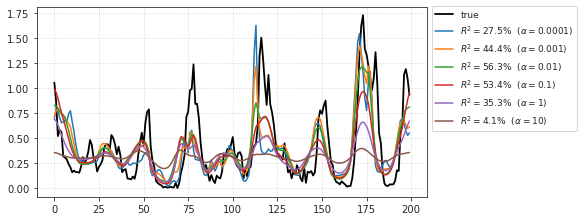

In [21]:
glm.show_pred();

## Load model

In [24]:
%%time

from model.utils_model import load_model

model_name = 'k-32_z-7x[10,20]_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)'
fit_name = 'SampNoELU-ep2000-b500-lr(0.002)_beta(0.25:1x0.3)_lamb(0.01)_gr(1000)_(2023_04_02,21:01)'
tr_load, metadata = load_model(
    model_name=model_name,
    fit_name=fit_name,
    device='cuda:2',
    verbose=True,
)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  17.0 Mil  |
|     ---      |    ---     |
|     stem     |   1.1 K    |
| pre_process  |   96.0 K   |
|  enc_tower   |  9.4 Mil   |
|     enc0     |   16.6 K   |
| enc_sampler  |  1.4 Mil   |
| dec_sampler  |  1.4 Mil   |
|    expand    |   71.0 K   |
|  dec_tower   |  4.5 Mil   |
| post_process |   40.0 K   |
|     out      |    578     |
+--------------+------------+

# params: 17.0 M

CPU times: user 20 s, sys: 1.4 s, total: 21.4 s
Wall time: 4.84 s


In [25]:
print(list(metadata.items())[:2])

[('checkpoint', 750), ('global_step', 60000)]

In [26]:
%%time

val, loss = tr_load.validate(use_ema=False)
val_ema, loss_ema = tr_load.validate(use_ema=True)

CPU times: user 34.7 s, sys: 17.3 s, total: 52 s
Wall time: 48.1 s


In [27]:
loss_summary = {
    k: {
        'vae': np.round(v.mean(), 2),
        'ema': np.round(loss_ema[k].mean(), 2),
    } for k, v in loss.items()
}
print(loss_summary)

{'epe': {'vae': 3.62, 'ema': 3.59}, 'kl': {'vae': 29.59, 'ema': 29.61}}

fig/sample (VAE)

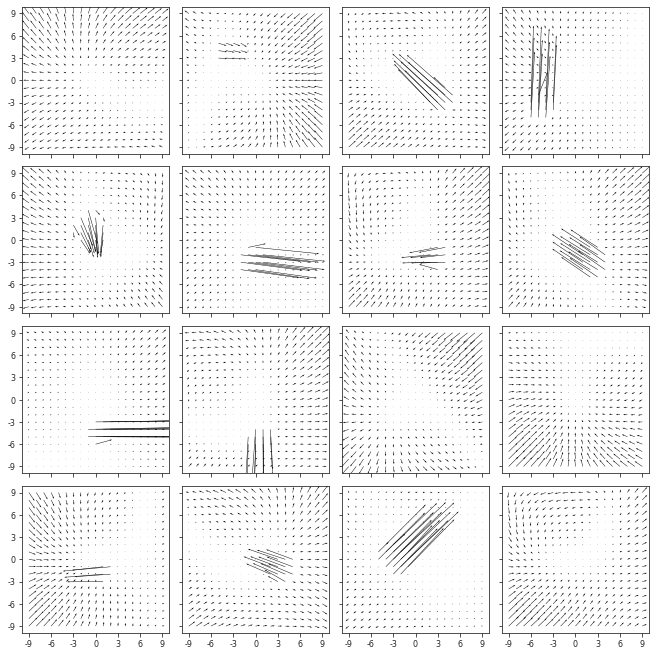

fig/sample (EMA)

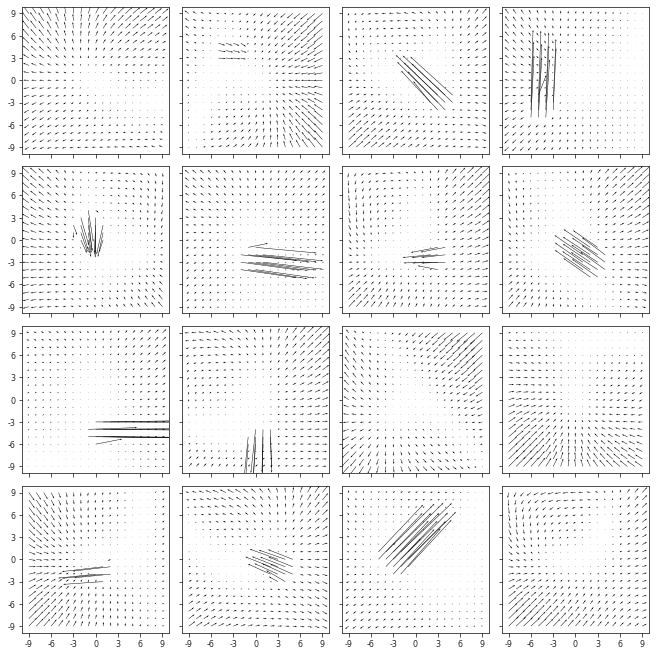

----------------------------------------------------------------------

fig/regression (VAE)

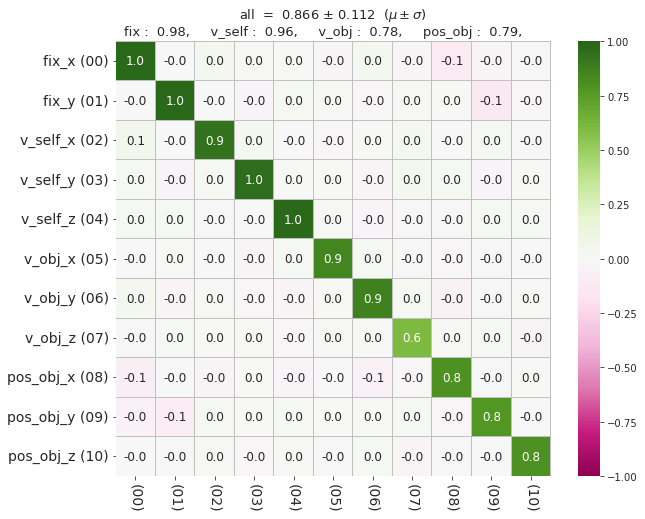

fig/regression (EMA)

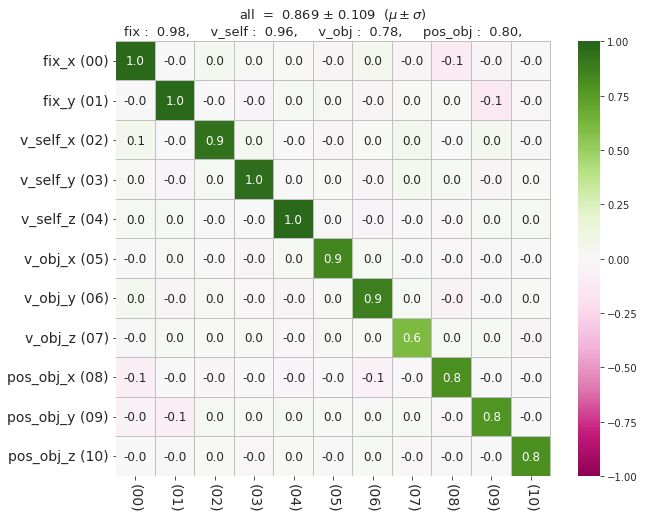

----------------------------------------------------------------------

fig/mutual_info (VAE)

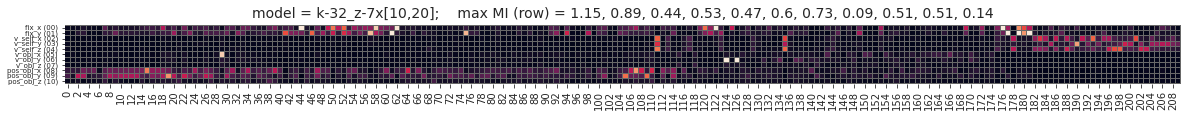

fig/mutual_info (EMA)

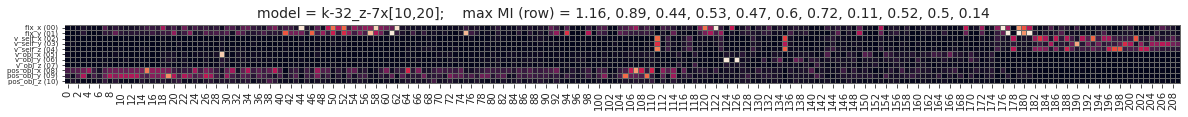

----------------------------------------------------------------------

In [28]:
for k, v in val.items():
    if 'fig' in k:
        print(f"{k} (VAE)")
        display(v)
        print(f"{k} (EMA)")
        display(val_ema[k])
        print('-' * 70)

In [29]:
np.max(val_ema['regr/mi'], axis=1).mean()

0.5529721824025903

### Xtract ftrs (loaded model)

In [30]:
# Stim
enc = []
for i in tqdm(range(int(np.ceil(len(stim) / tr_load.cfg.batch_size)))):
    a = i * tr_load.cfg.batch_size
    b = min(a + tr_load.cfg.batch_size, len(stim))
    x = tr_load.to(np.transpose(stim[a:b], (0, -1, 1, 2)))
    *_, ftr = tr_load.model_ema.xtract_ftr(x, full=True)
    e4 = torch.cat(ftr['enc'][4], dim=1)
    e8 = torch.nn.functional.interpolate(
        input=torch.cat(ftr['enc'][8], dim=1),
        scale_factor=0.5,
        mode='nearest',
    )
    enc.append(to_np(F.relu(torch.cat([e4, e8], dim=1))))
enc = np.concatenate(enc)

# Stim Repeat
x = tr_load.to(np.transpose(stim_r[:800], (0, -1, 1, 2)))
*_, ftr = tr_load.model_ema.xtract_ftr(x, full=True)
e4_r = torch.cat(ftr['enc'][4], dim=1)
e8_r = torch.nn.functional.interpolate(
    input=torch.cat(ftr['enc'][8], dim=1),
    scale_factor=0.5,
    mode='nearest',
)
enc_r = to_np(F.relu(torch.cat([e4_r, e8_r], dim=1)))

enc.shape, enc_r.shape

100%|██████████| 144/144 [00:54<00:00,  2.64it/s]


((72000, 5248, 4, 4), (800, 5248, 4, 4))

In [31]:
%%time

i, j = 1, 2
neuron_i = 0

glm_kws = dict(
    category='PoissonRegressor',
    x=enc[idxs - lag, ..., i, j],
    y=spks[idxs, neuron_i],
    x_tst=enc_r[np.array(intvl) - lag, ..., i, j],
    y_tst=np.nanmean(spks_r[neuron_i], 0),
    alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],
)
glm_loaded = LinearModel(**glm_kws).fit(fit_df=False)

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (m

CPU times: user 1h 18min 32s, sys: 15min 4s, total: 1h 33min 37s
Wall time: 23min 44s


In [32]:
glm_loaded.r2_tst

{0.0001: 52.65765768703603,
 0.001: 58.3685728560561,
 0.01: 59.001416671696624,
 0.1: 56.738875284364276,
 1: 56.69520721364041,
 10.0: 53.013503662791784}

In [33]:
glm_loaded.r_tst

{0.0001: 0.7317584221691353,
 0.001: 0.7701369757052705,
 0.01: 0.774550858419044,
 0.1: 0.755606397172111,
 1: 0.764587622695825,
 10.0: 0.7718896363343437}

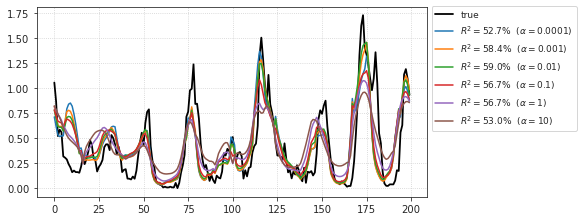

In [34]:
glm_loaded.show_pred();

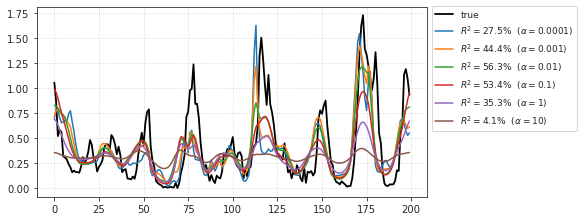

In [35]:
glm.show_pred();

In [36]:
u, s, v = sp_lin.svd(
    a=enc[idxs - lag, ..., 1, 1],
    full_matrices=False,
)
s /= s.sum()

In [37]:
np.round(s * 100)[:20]

array([12.,  3.,  3.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

## Another neuron

In [2]:
from common.dataset import setup_supervised_data, setup_repeat_data, time_embed

cfg = ConfigVAE(save=False)
file = h5py.File(cfg.h_file, 'r')
expt = 'clu095'
grp = file[expt]

In [3]:
hf_kws = {
    'size': 19,
    'sres': 1,
    'radius': 6,
}
hf = HyperFlow(
    params=np.array(grp['hyperflow'])[:, 2:],
    center=np.array(grp['hyperflow'])[:, :2],
    **hf_kws,
)
stim = hf.compute_hyperflow()
spks = np.array(grp['spks'], dtype=float)
good = ~np.array(grp['badspks'])
good = np.where(good)[0]

# lags = 16
# src, tgt = setup_supervised_data(lags, good, stim, spks)
stim_r, spks_r, intvl = setup_repeat_data(grp, lags=None, hf_kws=hf_kws)
stim.shape, stim_r.shape

((72000, 19, 19, 2), (36000, 19, 19, 2))

### Reservoir

In [4]:
vae = VAE(ConfigVAE(
    n_kers=4,
    n_latent_scales=2, n_groups_per_scale=20, n_latent_per_group=7,
    scale_init=False, residual_kl=True, ada_groups=True,
))
tr = TrainerVAE(model=vae, cfg=ConfigTrainVAE(batch_size=500), device='cuda:1')
vae.cfg.total_latents()

210

#### Extract features

In [10]:
from common.utils_model import F

In [11]:
# Stim
enc = []
for i in tqdm(range(int(np.ceil(len(stim) / tr.cfg.batch_size)))):
    a = i * tr.cfg.batch_size
    b = min(a + tr.cfg.batch_size, len(stim))
    x = tr.to(np.transpose(stim[a:b], (0, -1, 1, 2)))
    *_, ftr = tr.model.xtract_ftr(x, full=True)
    enc.append(to_np(F.silu(F.interpolate(
        input=torch.cat(ftr['enc'][8], dim=1),
        scale_factor=0.5,
        mode='bilinear',
    ))))
enc = np.concatenate(enc)

# Stim Repeat
x = tr.to(np.transpose(stim_r[:1000], (0, -1, 1, 2)))
*_, ftr = tr.model.xtract_ftr(x, full=True)
enc_r = to_np(F.silu(F.interpolate(
    input=torch.cat(ftr['enc'][8], dim=1),
    scale_factor=0.5,
    mode='bilinear',
)))

enc.shape, enc_r.shape

100%|██████████| 144/144 [00:47<00:00,  3.04it/s]


((72000, 2560, 4, 4), (1000, 2560, 4, 4))

## PCA

In [12]:
from sklearn.decomposition import PCA

In [13]:
pc = PCA(n_components=500)
x = pc.fit_transform(flatten_arr(enc, ndim_end=0, ndim_start=1))
x_r = pc.transform(flatten_arr(enc_r, ndim_end=0, ndim_start=1))

x.shape, x_r.shape

((72000, 500), (1000, 500))

In [37]:
src = time_embed(x, lags=10, idxs=good)
src_r = time_embed(x_r, lags=10, idxs=intvl)
src.shape, src_r.shape

((48918, 10, 500), (200, 10, 500))

In [38]:
from analysis.linear import LinearModel

In [54]:
%%time

neuron_i = 0

glm_kws = dict(
    category='Ridge',
    x=src,
    y=spks[good, neuron_i],
    x_tst=src_r,
    y_tst=np.nanmean(spks_r[neuron_i], 0),
    alphas=[1e4, 5e4, 1e5, 5e5],
)
glm = LinearModel(**glm_kws).fit(fit_df=False)

CPU times: user 3min 58s, sys: 2.71 s, total: 4min
Wall time: 23 s


In [55]:
glm.r2_tst

{10000.0: 39.66455184525773,
 50000.0: 55.422887066428885,
 100000.0: 55.35132559206532,
 500000.0: 48.919083349881575}

In [56]:
glm.r_tst

{10000.0: 0.7405560644191935,
 50000.0: 0.7569644800173236,
 100000.0: 0.7477394055413082,
 500000.0: 0.713376261208507}

In [57]:
glm.df

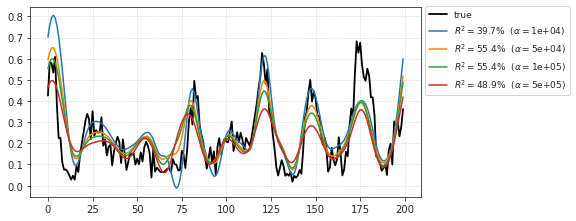

In [58]:
glm.show_pred();

### GLM to reservoir

In [56]:
%%time

results = np.zeros((4, 4))
neuron_i = 0
for i, j in itertools.product(range(4), range(4)):
    glm_kws = dict(
        category='PoissonRegressor',
        x=enc[idxs - lag, ..., i, j],
        y=spks[idxs, neuron_i],
        x_tst=enc_r[np.array(intvl) - lag, ..., i, j],
        y_tst=np.nanmean(spks_r[neuron_i], 0),
        alphas=[10],
    )
    glm = LinearModel(**glm_kws).fit(fit_df=False)
    print(i, j, glm.r2_tst)
    results[i, j] = glm.r2_tst[10]

0 0
{10: 3.0910641369208847}

0 1
{10: 10.181404269355387}

0 2
{10: 11.475897704402549}

0 3
{10: 3.103440232195709}

1 0
{10: 8.163266676184888}

1 1
{10: 20.055160262565618}

1 2
{10: 17.406201366075248}

1 3
{10: 4.936008330245489}

2 0
{10: 8.98864616342413}

2 1
{10: 12.773642532989848}

2 2
{10: 9.125710022034495}

2 3
{10: 1.009867505285389}

3 0
{10: 2.0905470008007465}

3 1
{10: 5.023415714503621}

3 2
{10: 1.3742440553512147}

3 3
{10: 0.14141449366251724}

CPU times: user 24min 1s, sys: 4min 15s, total: 28min 17s
Wall time: 6min 53s


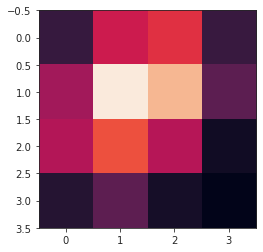

In [58]:
plt.imshow(results)

In [61]:
%%time

i, j = 1, 1
neuron_i = 0

glm_kws = dict(
    category='PoissonRegressor',
    x=enc[idxs - lag, ..., i, j],
    y=spks[idxs, neuron_i],
    x_tst=enc_r[np.array(intvl) - lag, ..., i, j],
    y_tst=np.nanmean(spks_r[neuron_i], 0),
    alphas=[1, 5, 10, 50, 100],
)
glm = LinearModel(**glm_kws).fit(fit_df=False)

CPU times: user 8min 31s, sys: 1min 32s, total: 10min 4s
Wall time: 2min 26s


In [62]:
glm.r2_tst

{1: -128.77879386199166,
 5: 7.573802641029548,
 10: 20.055160262565618,
 50: 8.509335000003205,
 100: 4.632866256568691}

In [65]:
glm.r_tst

{1: 0.417512868962454,
 5: 0.4305915952594444,
 10: 0.4479998114768849,
 50: 0.4685808001371135,
 100: 0.47145838903574583}

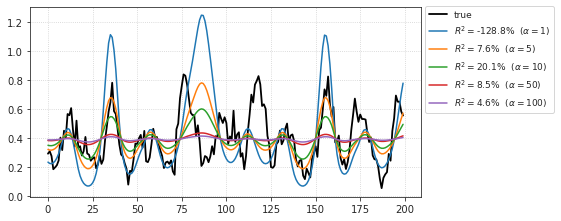

In [66]:
glm.show_pred();

## Load model

In [4]:
%%time

from common.utils_model import load_model

model_name = 'k-32_z-7x[10,20]_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)'
fit_name = 'SampNoELU-ep2000-b500-lr(0.002)_beta(0.25:1x0.3)_lamb(0.01)_gr(1000)_(2023_04_02,21:01)'
tr_load, metadata = load_model(
    model_name=model_name,
    fit_name=fit_name,
    device='cuda:2',
    verbose=True,
)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  17.0 Mil  |
|     ---      |    ---     |
|     stem     |   1.1 K    |
| pre_process  |   96.0 K   |
|  enc_tower   |  9.4 Mil   |
|     enc0     |   16.6 K   |
| enc_sampler  |  1.4 Mil   |
| dec_sampler  |  1.4 Mil   |
|    expand    |   71.0 K   |
|  dec_tower   |  4.5 Mil   |
| post_process |   40.0 K   |
|     out      |    578     |
+--------------+------------+

# params: 17.0 M

CPU times: user 27.8 s, sys: 3.14 s, total: 30.9 s
Wall time: 12.2 s


In [5]:
print(list(metadata.items())[:2])

[('checkpoint', 750), ('global_step', 60000)]

In [8]:
x, norm = next(iter(tr_load.dl_tst))
with torch.no_grad():
    y, z, q, p = tr_load.model(x)

In [21]:
sig_q, sig_p = [], []

for dist in q:
    sig_q.extend(list(to_np(dist.sigma.ravel())))
for dist in p:
    sig_p.extend(list(to_np(dist.sigma.ravel())))

len(sig_p), len(sig_q)

(105000, 105000)

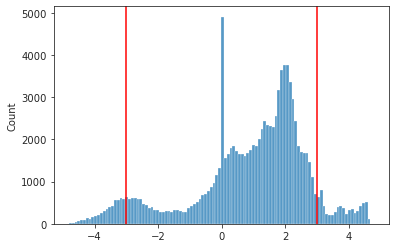

In [23]:
sns.histplot(np.log(sig_p))
plt.axvline(3, color='r')
plt.axvline(-3, color='r');

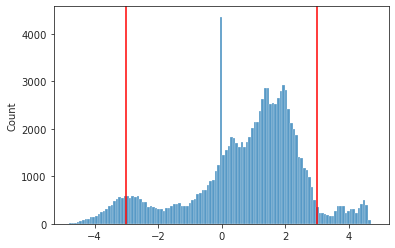

In [24]:
sns.histplot(np.log(sig_q))
plt.axvline(3, color='r')
plt.axvline(-3, color='r');

In [61]:
%%time

val, loss = tr_load.validate(use_ema=False)
val_ema, loss_ema = tr_load.validate(use_ema=True)

loss_summary = {
    k: {
        'vae': np.round(v.mean(), 2),
        'ema': np.round(loss_ema[k].mean(), 2),
    } for k, v in loss.items()
}
print(loss_summary)

{'epe': {'vae': 3.62, 'ema': 3.59}, 'kl': {'vae': 29.59, 'ema': 29.61}}

CPU times: user 26.7 s, sys: 15.1 s, total: 41.8 s
Wall time: 49.8 s


### Begin copy from above

In [62]:
from common.utils_model import F

In [63]:
# Stim
enc = []
for i in tqdm(range(int(np.ceil(len(stim) / tr_load.cfg.batch_size)))):
    a = i * tr_load.cfg.batch_size
    b = min(a + tr_load.cfg.batch_size, len(stim))
    x = tr_load.to(np.transpose(stim[a:b], (0, -1, 1, 2)))
    *_, ftr = tr_load.model.xtract_ftr(x, full=True)
    enc.append(to_np(F.silu(F.interpolate(
        input=torch.cat(ftr['enc'][8], dim=1),
        scale_factor=0.5,
        mode='bilinear',
    ))))
enc = np.concatenate(enc)

# Stim Repeat
x = tr_load.to(np.transpose(stim_r[:1000], (0, -1, 1, 2)))
*_, ftr = tr_load.model.xtract_ftr(x, full=True)
enc_r = to_np(F.silu(F.interpolate(
    input=torch.cat(ftr['enc'][8], dim=1),
    scale_factor=0.5,
    mode='bilinear',
)))

enc.shape, enc_r.shape

100%|██████████| 144/144 [00:46<00:00,  3.07it/s]


((72000, 2560, 4, 4), (1000, 2560, 4, 4))

#### PCA

In [64]:
from sklearn.decomposition import PCA

In [65]:
pc = PCA(n_components=500)
x = pc.fit_transform(flatten_arr(enc, ndim_end=0, ndim_start=1))
x_r = pc.transform(flatten_arr(enc_r, ndim_end=0, ndim_start=1))
x.shape, x_r.shape

((72000, 500), (1000, 500))

In [66]:
src = time_embed(x, lags=10, idxs=good)
src_r = time_embed(x_r, lags=10, idxs=intvl)
src.shape, src_r.shape

((48918, 10, 500), (200, 10, 500))

In [67]:
from analysis.linear import LinearModel

In [98]:
%%time

neuron_i = 0

glm_kws = dict(
    category='Ridge',
    x=src,
    y=spks[good, neuron_i],
    x_tst=src_r,
    y_tst=np.nanmean(spks_r[neuron_i], 0),
    alphas=[3e6, 1e7],
)
glm_load = LinearModel(**glm_kws).fit(fit_df=False)

CPU times: user 1min 40s, sys: 1.2 s, total: 1min 42s
Wall time: 8.98 s


In [99]:
glm_load.r2_tst

{3000000.0: 60.543522192473716, 10000000.0: 56.915591884836026}

In [100]:
glm_load.r_tst

{3000000.0: 0.7981952906982575, 10000000.0: 0.7907409405834221}

In [101]:
glm_load.df

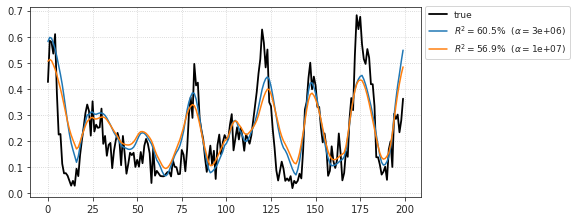

In [102]:
glm_load.show_pred();

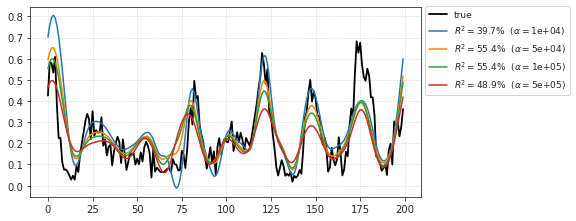

In [103]:
glm.show_pred();

### End copy from above

### Xtract ftrs (loaded model)

In [86]:
# Stim
enc = []
for i in tqdm(range(int(np.ceil(len(stim) / tr_load.cfg.batch_size)))):
    a = i * tr_load.cfg.batch_size
    b = min(a + tr_load.cfg.batch_size, len(stim))
    x = tr_load.to(np.transpose(stim[a:b], (0, -1, 1, 2)))
    *_, ftr = tr_load.model.xtract_ftr(x, full=True)
    e4 = torch.cat(ftr['enc'][4], dim=1)
    # e8 = torch.nn.functional.interpolate(
    #     input=torch.cat(ftr['enc'][8], dim=1),
    #     scale_factor=0.5,
    #     mode='nearest',
   #  )
   #  enc.append(to_np(F.relu(torch.cat([e4, e8], dim=1))))
    enc.append(to_np(F.silu(e4)))
enc = np.concatenate(enc)

# Stim Repeat
x = tr_load.to(np.transpose(stim_r[:800], (0, -1, 1, 2)))
*_, ftr = tr_load.model.xtract_ftr(x, full=True)
e4_r = torch.cat(ftr['enc'][4], dim=1)
# e8_r = torch.nn.functional.interpolate(
#     input=torch.cat(ftr['enc'][8], dim=1),
#     scale_factor=0.5,
#     mode='nearest',
# )
# enc_r = to_np(F.relu(torch.cat([e4_r, e8_r], dim=1)))
enc_r = to_np(F.silu(e4_r))

enc = enc[idxs - lag]
enc_r = enc_r[np.array(intvl) - lag]

enc.shape, enc_r.shape

100%|██████████| 144/144 [00:44<00:00,  3.21it/s]


((45318, 2688, 4, 4), (200, 2688, 4, 4))

In [87]:
x = flatten_arr(
    np.concatenate([enc, enc_r]),
    ndim_end=0,
    ndim_start=1,
)
x.shape

(45518, 43008)

In [88]:
from sklearn.decomposition import PCA

pc = PCA(n_components=500).fit(x)
x_reduced = pc.transform(x)
x_reduced.shape

(45518, 500)

In [100]:
%%time

neuron_i = 0

glm_kws = dict(
    category='PoissonRegressor',
    x=x_reduced[:len(enc)],
    y=spks[idxs, neuron_i],
    x_tst=x_reduced[len(enc):],
    y_tst=np.nanmean(spks_r[neuron_i], 0),
    alphas=[1e-3, 1e-2, 1e-1, 1e4, 1e5],
)
glm = LinearModel(**glm_kws).fit(fit_df=False)

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (m

CPU times: user 7min 17s, sys: 46 s, total: 8min 3s
Wall time: 1min 14s


In [101]:
glm.r2_tst

{0.001: -209.27657178444582,
 0.01: -227.1945908729253,
 0.1: -207.9894773760104,
 10000.0: -1.7384777993558087,
 100000.0: -0.038893103746850954}

In [102]:
glm.r_tst

{0.001: 0.3491676659380304,
 0.01: 0.3339972285048517,
 0.1: 0.34968155511580434,
 10000.0: -0.04193013954100826,
 100000.0: -0.06611467414227247}

In [103]:
glm.df

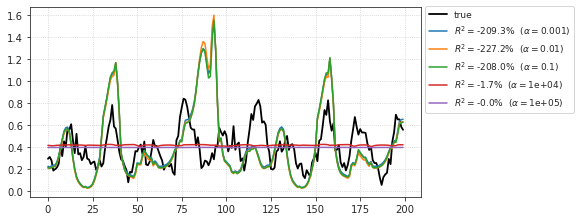

In [104]:
glm.show_pred();

## GLM but other extract

In [70]:
# Stim
enc = []
for i in tqdm(range(int(np.ceil(len(stim) / tr_load.cfg.batch_size)))):
    a = i * tr_load.cfg.batch_size
    b = min(a + tr_load.cfg.batch_size, len(stim))
    x = tr_load.to(np.transpose(stim[a:b], (0, -1, 1, 2)))
    *_, ftr = tr_load.model_ema.xtract_ftr(x, full=True)
    e4 = torch.cat(ftr['enc'][4], dim=1)
    e8 = torch.nn.functional.interpolate(
        input=torch.cat(ftr['enc'][8], dim=1),
        scale_factor=0.5,
        mode='nearest',
    )
    enc.append(to_np(F.relu(torch.cat([e4, e8], dim=1))))
enc = np.concatenate(enc)

# Stim Repeat
x = tr_load.to(np.transpose(stim_r[:800], (0, -1, 1, 2)))
*_, ftr = tr_load.model_ema.xtract_ftr(x, full=True)
e4_r = torch.cat(ftr['enc'][4], dim=1)
e8_r = torch.nn.functional.interpolate(
    input=torch.cat(ftr['enc'][8], dim=1),
    scale_factor=0.5,
    mode='nearest',
)
enc_r = to_np(F.relu(torch.cat([e4_r, e8_r], dim=1)))

enc.shape, enc_r.shape

100%|██████████| 144/144 [00:54<00:00,  2.64it/s]


((72000, 5248, 4, 4), (800, 5248, 4, 4))

In [88]:
%%time

glm_load = LinearModel(**glm_kws).fit(fit_df=False)

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


CPU times: user 43min 17s, sys: 7min 57s, total: 51min 14s
Wall time: 12min 38s


In [95]:
glm_load.r2_tst

{1: -131.97868850210858,
 5: -154.07809038233358,
 10: -143.67793412854883,
 50: -76.94085777233448,
 100: -38.02739274329807}

In [96]:
glm_load.r_tst

{1: 0.5296850028704132,
 5: 0.4956041982357747,
 10: 0.4822644916968304,
 50: 0.4433985792244645,
 100: 0.42261713980422594}

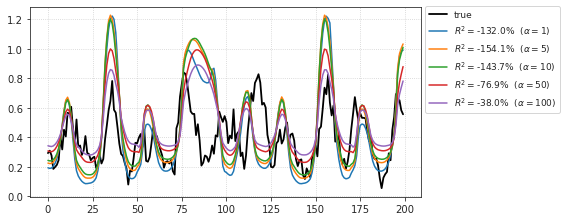

In [98]:
glm_load.show_pred();

In [76]:
u, s, v = sp_lin.svd(
    a=enc[idxs - lag, ..., 1, 1],
    full_matrices=False,
)
s *= 100 / s.sum()

In [78]:
np.round(s)[:20]

array([12.,  3.,  3.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  0.], dtype=float32)

In [100]:
enc.shape, enc_r.shape

((72000, 5248, 4, 4), (800, 5248, 4, 4))

In [101]:
x = np.concatenate([enc, enc_r])
x.shape

(72800, 5248, 4, 4)

In [ ]:
flatten_arr(x, ndim_end=1, ndim_start=0).shape

## Load --> STA

In [47]:
from model.dataset import setup_supervised_data
from analysis.sta import compute_sta

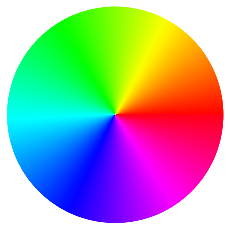

In [48]:
_ = show_hsv()

clu044,  good: 81.5 %

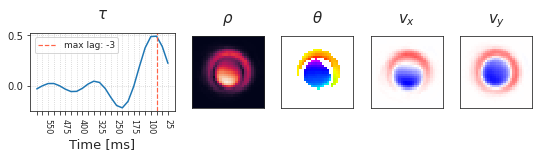

______________________________________________________________________

Done.

CPU times: user 1min 1s, sys: 2.07 s, total: 1min 3s
Wall time: 19.9 s


In [71]:
%%time

file = h5py.File(tr.model.cfg.h_file, 'r')

lags = 24
df, good_percent = [], []
for name in file:
    if name != 'clu044':
        continue
    group = file[name]
    spks = np.array(group['spks'], dtype=float)
    good = ~np.array(group['badspks'])
    percent = 100 * good.sum() / len(good)
    good_percent.append(percent)
    print(f"{name},  good: {percent:0.1f} %")

    hf = HyperFlow(
        params=np.array(group['hyperflow'])[:, 2:],
        center=np.array(group['hyperflow'])[:, :2],
        size=32,
        sres=1,
        radius=8,
    )
    stim = hf.compute_hyperflow()
    sta = compute_sta(
        lags=lags,
        good=np.where(good)[0],
        stim=stim,
        spks=spks,
    )
    sta = VelField(sta, name=name)
    _ = sta.show()
    
    for ch, a in enumerate(sta.rho):
        mask = a > np.quantile(a, 0.75)
        i, j = np.where(mask)
        df.append({
            'name': [name] * mask.sum(),
            'channel': [ch] * mask.sum(),
            'theta': sta.theta[ch][mask],
            'x': i,
            'y': j,
        })
    print('_' * 70)
    print('\n')

df = pd.DataFrame(merge_dicts(df))
print('Done.')
file.close()

In [72]:
sta.x.shape

(1, 24, 32, 32, 2)

In [73]:
sta.maxlag.item()

21

In [74]:
a = sta.x[0, sta.maxlag.item()]
a.shape

(32, 32, 2)

In [75]:
%%time

file = h5py.File(tr.model.cfg.h_file, 'r')

lags = 24
df, good_percent = [], []
for name in file:
    if name != 'clu044':
        continue
    group = file[name]
    spks = np.array(group['spks'], dtype=float)
    good = ~np.array(group['badspks'])
    percent = 100 * good.sum() / len(good)
    good_percent.append(percent)
    print(f"{name},  good: {percent:0.1f} %")

clu044,  good: 81.5 %

CPU times: user 11.9 ms, sys: 229 µs, total: 12.1 ms
Wall time: 10.5 ms


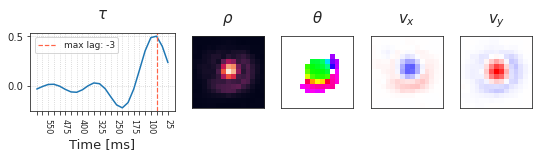

In [76]:
stim = np.array(group['stim1'])
sta_log = compute_sta(
    lags=lags,
    good=np.where(good)[0],
    stim=stim,
    spks=spks,
)
sta_log = VelField(sta_log, name=name)
_ = sta_log.show()

In [77]:
a_log = sta_log.x[0, sta_log.maxlag.item()]
a_log.shape

(15, 15, 2)

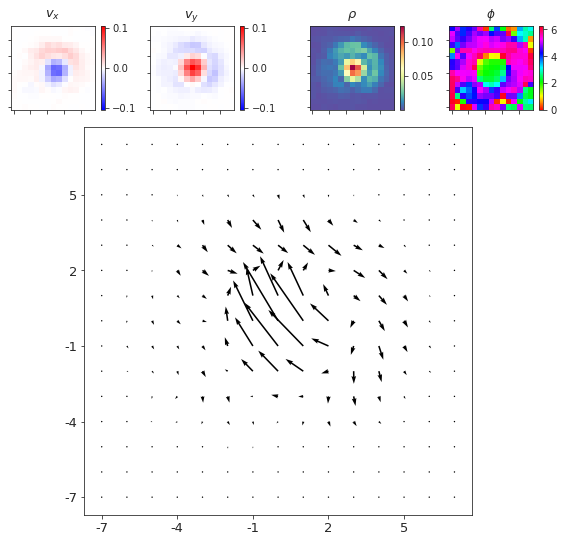

In [78]:
show_opticflow_full(a_log, scale=0.7);

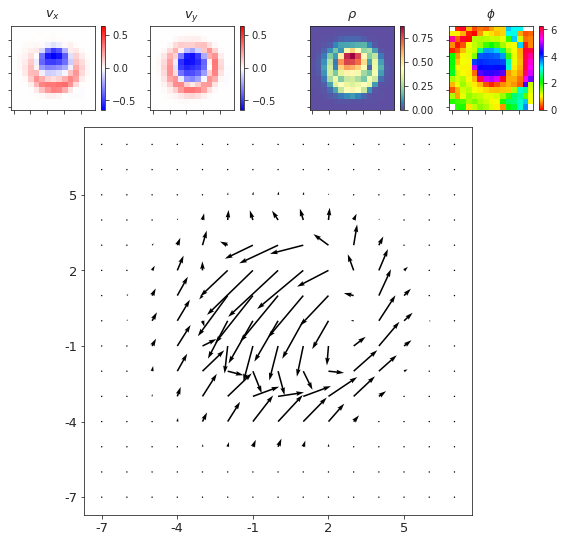

In [81]:
from skimage.transform import resize
show_opticflow_full(resize(a, (15, 15, 2)), scale=5);

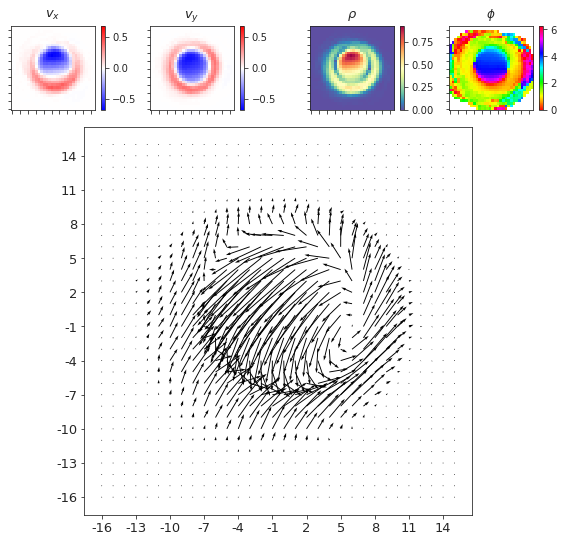

In [82]:
show_opticflow_full(a, scale=5);

In [94]:
stim.shape, hf.stim.shape

((76800, 15, 15, 2), (76800, 32, 32, 2))

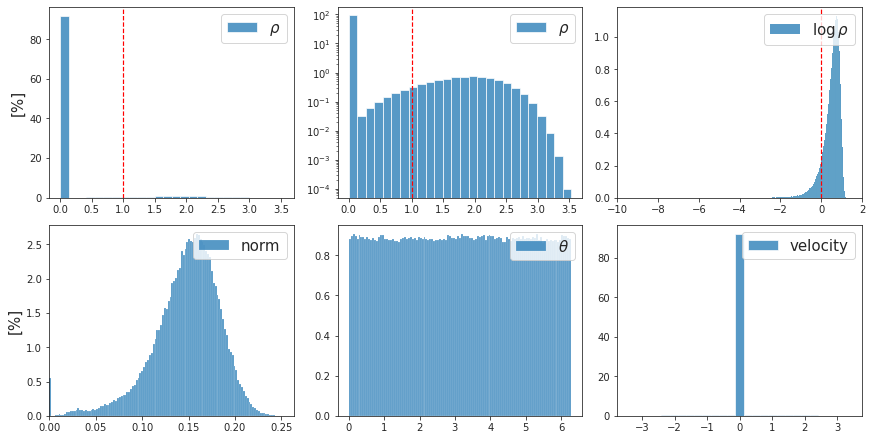

(<Figure size 864x432 with 6 Axes>,
 array([[<AxesSubplot:ylabel='[%]'>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='[%]'>, <AxesSubplot:>, <AxesSubplot:>]],
       dtype=object))

In [92]:
plot_opticflow_hist(stim)

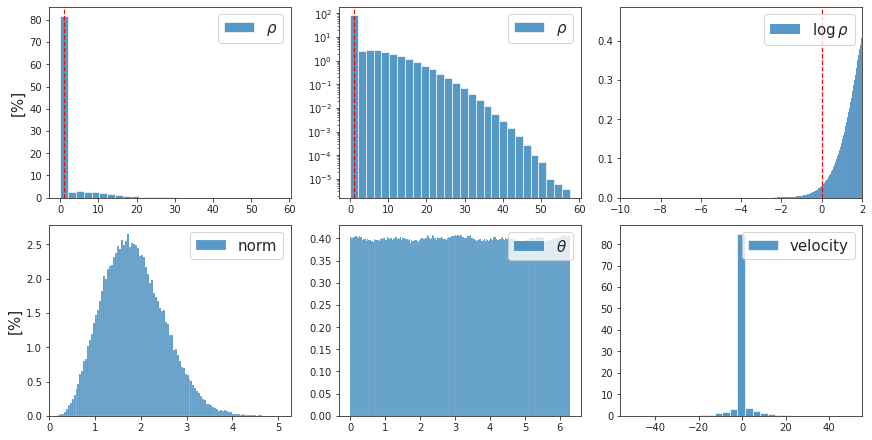

(<Figure size 864x432 with 6 Axes>,
 array([[<AxesSubplot:ylabel='[%]'>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='[%]'>, <AxesSubplot:>, <AxesSubplot:>]],
       dtype=object))

In [91]:
plot_opticflow_hist(hf.stim);

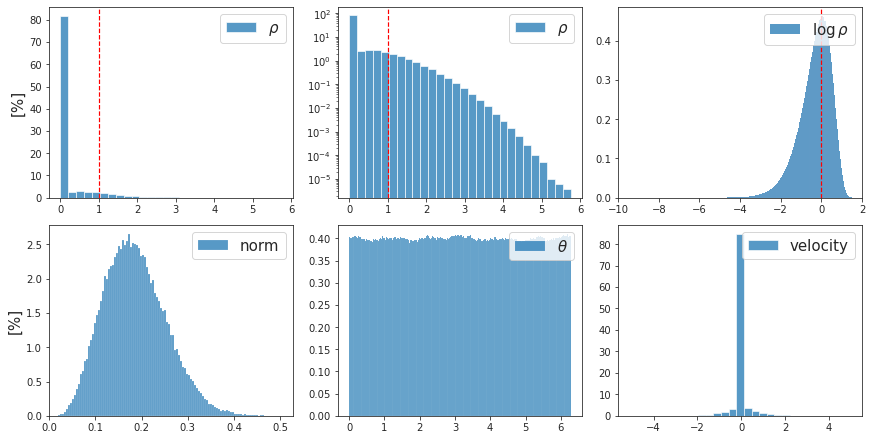

In [95]:
plot_opticflow_hist(hf.stim / 10);

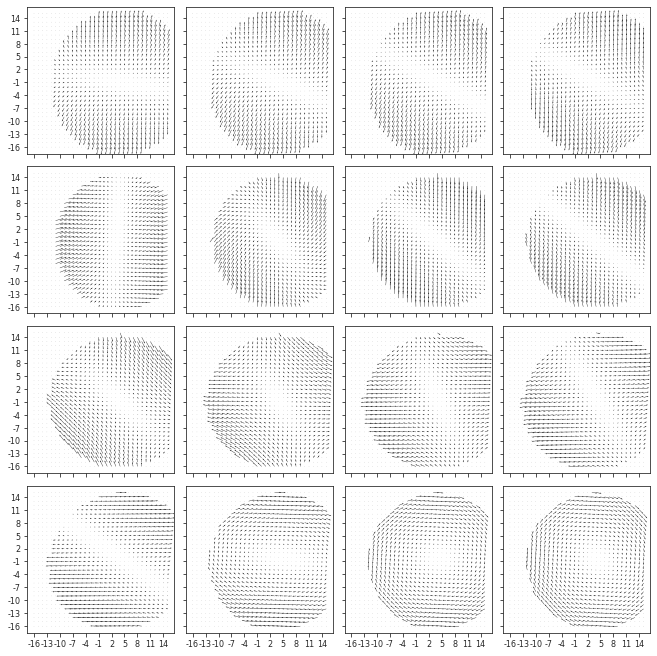

In [103]:
show_opticflow(hf.stim);

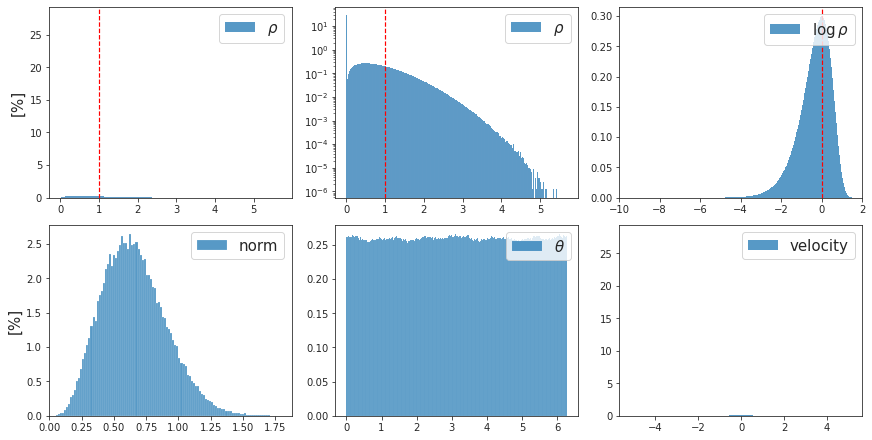

In [105]:
plot_opticflow_hist(hf.stim / 20);

<AxesSubplot:ylabel='Count'>

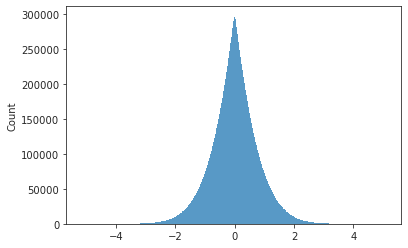

In [108]:
x = hf.stim / 20
sns.histplot(x[x.nonzero()].ravel())

In [210]:
# from model.dataset import setup_repeat_data

def setup_repeat_data(
        group: h5py.Group,
        lags: int,
        stim: str = 'stimR', ):
    if 'repeats' not in group:
        return None, None
    group = group['repeats']
    psth = np.array(group['psth_raw_all'], dtype=float)
    badspks = np.array(group['fix_lost_all'], dtype=bool)
    tstart = np.array(group['tind_start_all'], dtype=int)
    assert (tstart == tstart[0]).all()
    tstart = tstart[0]
    nc, _, length = psth.shape

    # stim
    hf = HyperFlow(
        params=np.array(group['hyperflowR'])[:, 2:],
        center=np.array(group['hyperflowR'])[:, :2],
        size=19,
        sres=1,
        radius=4,
    )
    stim = hf.compute_hyperflow()
    # stim = np.array(group[stim], dtype=float)
    intvl = range(tstart[1], tstart[1] + length)
    src = time_embed(stim, lags, intvl)
    # spks
    spks = np.array(group['spksR'], dtype=float)
    tgt = np_nans(psth.shape)
    for i in range(nc):
        for trial, t in enumerate(tstart):
            s_ = range(t, t + length)
            tgt[i][trial] = spks[:, i][s_]
    tgt[badspks] = np.nan
    return src, tgt, intvl



def time_embed(x, lags, idxs=None):
	assert len(x) > lags
	if idxs is None:
		idxs = range(lags, len(x))
	x_emb = []
	for t in idxs:
		x_emb.append(np.expand_dims(
			x[t - lags: t], axis=0))
	return np.concatenate(x_emb)

In [211]:
name = 'clu095'
grp = file[name]
stim = np.array(grp['stim1'], dtype=float)
spks = np.array(grp['spks'], dtype=float)
good = ~np.array(grp['badspks'])
good = np.where(good)[0]

hf = HyperFlow(
    params=np.array(grp['hyperflow'])[:, 2:],
    center=np.array(grp['hyperflow'])[:, :2],
    size=19,
    sres=1,
    radius=4,
)
hf.compute_hyperflow();

src, tgt = setup_supervised_data(lags, good, stim, spks)
stim_r, spks_r, intvl = setup_repeat_data(grp, lags)

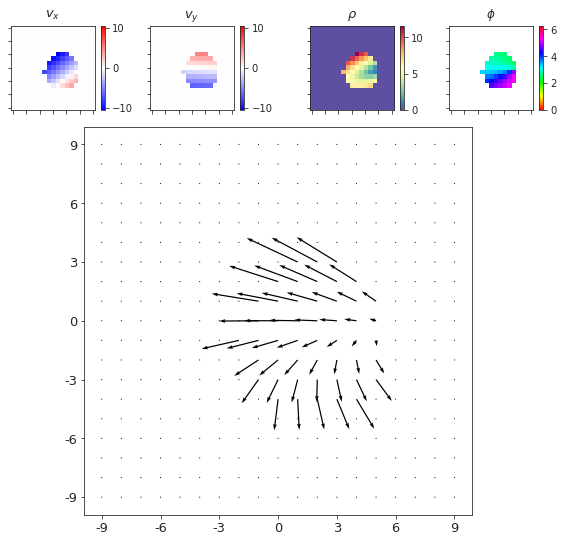

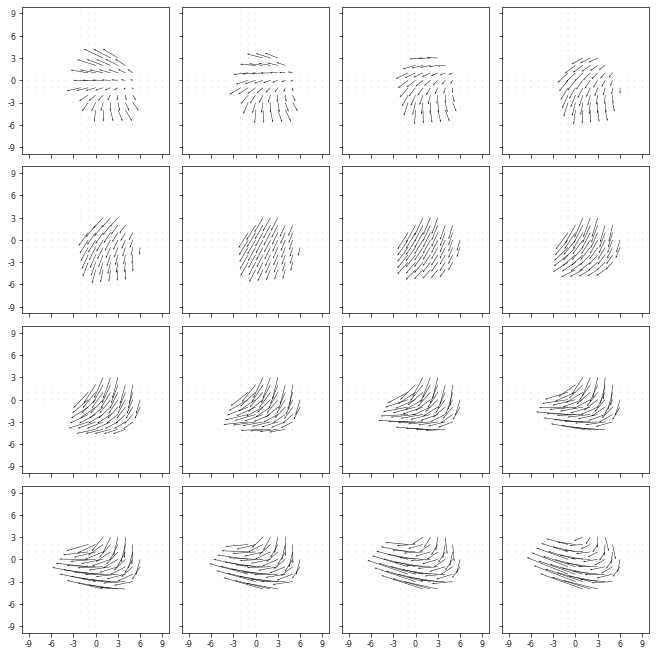

In [212]:
show_opticflow_full(hf.stim[0], scale=80);
show_opticflow(hf.stim, scale=80);

((72000, 15, 15, 2), (72000, 19, 19, 2))

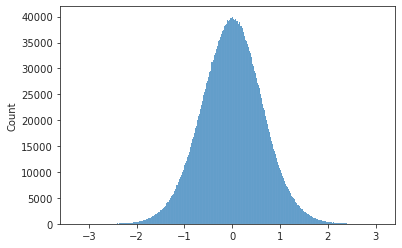

In [213]:
x = hf.stim / 10
sns.histplot(x[x.nonzero()].ravel())

stim.shape, x.shape

In [214]:
src, tgt = setup_supervised_data(lags, good, x, spks)
src.shape, tgt.shape

((48918, 24, 19, 19, 2), (48918, 1))

In [215]:
stim_r.shape, spks_r.shape

((200, 24, 19, 19, 2), (1, 117, 200))

In [216]:
from analysis.glm import GLM

In [217]:
i = 0 
if 'repeats' in grp:
    glm = GLM(src, tgt[:, i], stim_r, np.nanmean(spks_r[i], 0))
else:
    glm = GLM(src, tgt[:, i])
glm.fit()
nnll = glm.perf_df()
nnll = nnll.groupby(['alpha']).mean()['nnll']
nnll = dict(nnll)
if glm.r2:
    r2 = {
        k: v if v > 0 else np.nan
        for k, v in glm.r2.items()
    }
else:
    r2 = {
        a: np.nan for
        a in glm.alphas
    }

In [218]:
r2

{10: nan, 20: nan, 50: 36.83123182891717}

In [219]:
nnll

{10: 0.04187363739383878, 20: 0.026872528062477218, 50: 0.012903870127070505}

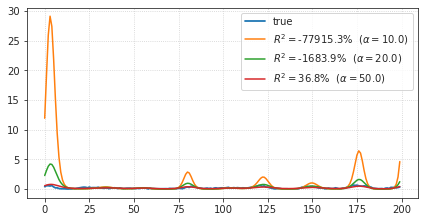

In [220]:
_ = glm.show_pred()

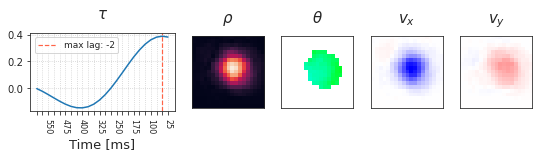

In [222]:
glm.kers[50].show();

In [223]:
glm

In [232]:
from analysis.glm import flatten_stim, PoissonRegressor, KFold

y = tgt[:, 0]

kf = KFold(
    n_splits=5,
    random_state=0,
    shuffle=True,
)

In [239]:
for trn, vld in kf.split(src):
    glm = PoissonRegressor(alpha=50)
    glm.fit(
        X=flatten_stim(src[trn]),
        y=y[trn],
    )
    pred = glm.predict(flatten_stim(src[vld]))
    nnll = null_adj_ll(y[vld], pred)
    print(nnll)

0.012369875564565369

0.01294145686367898

0.01188628688524851

0.01479633094409527

0.01272110936321269

In [358]:
r_cv = []
for trn, vld in kf.split(src):
    glm = linear_model.Ridge(alpha=50)
    glm.fit(
        X=flatten_stim(src[trn]),
        y=tgt[:, 0][trn],
    )
    pred = glm.predict(flatten_stim(src[vld]))
    r = sp_stats.pearsonr(pred, tgt[:, 0][vld])[0]
    r_cv.append(r)
    print(fold_i, r)
    # nnll = null_adj_ll(y[vld], pred)
    # print(nnll)
print(np.mean(r_cv))

4 0.16099509481453006

4 0.1569917012668178

4 0.14866688874620468

4 0.16696043985694403

4 0.1571014889892557

0.15814312273475045

In [241]:
ker = VelField(glm.coef_.reshape(src.shape[1:]))

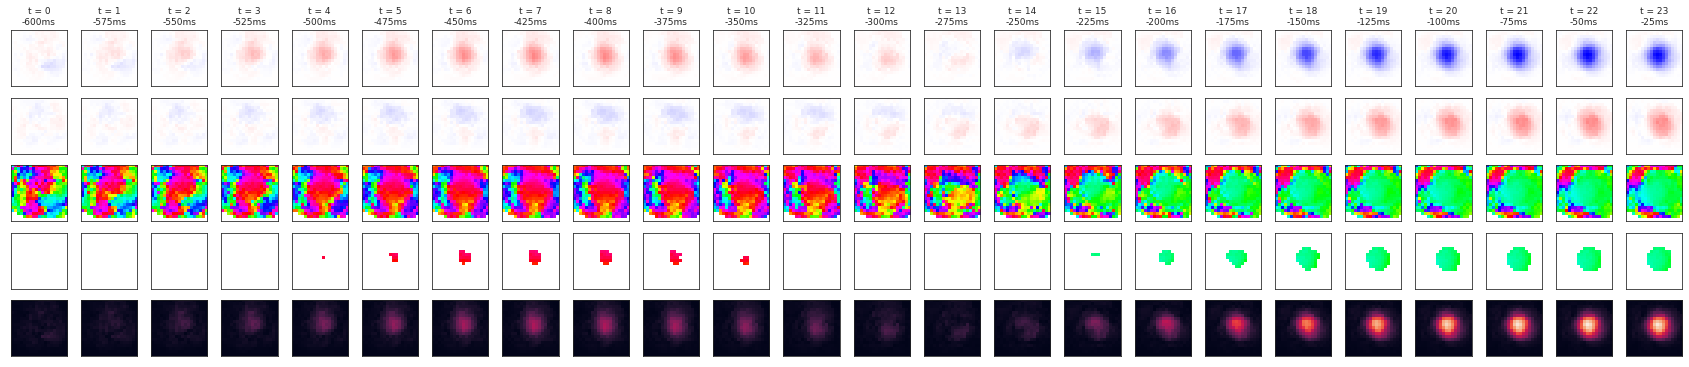

In [244]:
ker.show_full();

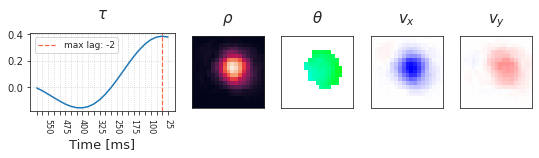

In [246]:
ker.show();

In [247]:
pred = glm.predict(flatten_stim(stim_r))

In [249]:
r2_score(np.nanmean(spks_r[0], 0), pred) * 100

36.63695535374122

In [255]:
x_vae = np.transpose(src[:, -2], (0, -1, 1, 2))
x_vae = tr.to(x_vae)
x_vae.size()

torch.Size([48918, 2, 19, 19])

In [257]:
x_vae.shape

torch.Size([48918, 2, 19, 19])

In [402]:
bsz = 60
num = int(np.ceil(len(x_vae) / bsz))
e8, e4, d8, d4 = [], [], [], []
for i in tqdm(range(num)):
    start = i * bsz
    end = min((i+1) * bsz, len(x_vae))
    y, z, q, p, ftr_enc, ftr_dec = tr.model_ema.xtract_ftr(
        x_vae[range(start, end)], t=0, full=True)
    e8.append(np.concatenate(ftr_enc[8], axis=1))
    e4.append(np.concatenate(ftr_enc[4], axis=1))
e8, e4 = cat_map([e8, e4])
e8.shape, e4.shape

  0%|          | 0/816 [00:00<?, ?it/s]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [279]:
e4.shape

(48918, 2688, 4, 4)

In [298]:
%%time

results = np.zeros((5, 4, 4))
for i, j in tqdm(itertools.product(range(4), range(4))):
    aaa = to_np(e4[..., i, j])
    for fold_i, (trn, vld) in enumerate(kf.split(aaa)):
        glm = PoissonRegressor(alpha=50)
        glm.fit(
            X=flatten_stim(aaa[trn]),
            y=tgt[:, 0][trn],
        )
        pred = glm.predict(flatten_stim(aaa[vld]))
        nnll = null_adj_ll(tgt[:, 0][vld], pred)
        if nnll > 0:
            results[fold_i, i, j] = nnll
        else:
            results[fold_i, i, j] = np.nan

0it [00:00, ?it/s]

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:42: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:323: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y / y_pred) - y + y_pred)
/home/

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:323: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y / y_pred) - y + y_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:323: RuntimeWarning: overflow encountered in true_divide
  dev = 2 * (xlogy(y, y / y_pred) - y + y_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:323: RuntimeWarning: invalid value encountered in true_divide
  dev = 2 * (xlogy(y, y / y_pred) - y + y_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:323: RuntimeWarning: invalid

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:323: RuntimeWarning: overflow encountered in true_divide
  dev = 2 * (xlogy(y, y / y_pred) - y + y_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:323: RuntimeWarning: invalid value encountered in true_divide
  dev = 2 * (xlogy(y, y / y_pred) - y + y_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:42: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:323: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y / y_pred) - y + y_pred)
/home/hadi/anaconda3/l

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:323: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y / y_pred) - y + y_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:323: RuntimeWarning: overflow encountered in true_divide
  dev = 2 * (xlogy(y, y / y_pred) - y + y_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:323: RuntimeWarning: invalid value encountered in true_divide
  dev = 2 * (xlogy(y, y / y_pred) - y + y_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sk

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in multiply
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:323: RuntimeWarning: invalid value encountered in add
  dev = 2 * (xlogy(y, y / y_pred) - y + y_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:323: RuntimeWarning: ove

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in multiply
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: invalid value e

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:323: RuntimeWarning: overflow encountered in true_divide
  dev = 2 * (xlogy(y, y / y_pred) - y + y_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:323: RuntimeWarning: invalid value encountered in true_divide
  dev = 2 * (xlogy(y, y / y_pred) - y + y_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/home/hadi/anaconda3

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:323: RuntimeWarning: overflow encountered in true_divide
  dev = 2 * (xlogy(y, y / y_pred) - y + y_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:323: RuntimeWarnin

CPU times: user 10h 57min 15s, sys: 11min 49s, total: 11h 9min 4s
Wall time: 34min 21s


<ipython-input-304-581d99182589>:1: RuntimeWarning: Mean of empty slice
  plt.imshow(np.nanmean(results, 0), vmin=0, cmap='magma')


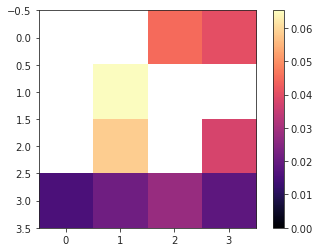

In [304]:
plt.imshow(np.nanmean(results, 0), vmin=0, cmap='magma')
plt.colorbar()

In [306]:
np.nanmax(np.nanmean(results, 0))

<ipython-input-306-0809e17a10ec>:1: RuntimeWarning: Mean of empty slice
  np.nanmax(np.nanmean(results, 0))


0.0652515126907935

In [247]:
pred = glm.predict(flatten_stim(stim_r))

In [249]:
r2_score(np.nanmean(spks_r[0], 0), pred) * 100

36.63695535374122

In [ ]:
%%time

results = np.zeros((5, 4, 4))
for i, j in tqdm(itertools.product(range(4), range(4))):
    aaa = to_np(e4[..., i, j])
    for fold_i, (trn, vld) in enumerate(kf.split(aaa)):
        glm = PoissonRegressor(alpha=50)
        glm.fit(
            X=flatten_stim(aaa[trn]),
            y=tgt[:, 0][trn],
        )
        pred = glm.predict(flatten_stim(aaa[vld]))
        nnll = null_adj_ll(tgt[:, 0][vld], pred)
        if nnll > 0:
            results[fold_i, i, j] = nnll
        else:
            results[fold_i, i, j] = np.nan

In [307]:
from sklearn import linear_model

In [320]:
%%time

i, j = 1, 1
aaa = to_np(e4[..., i, j])
ridge = linear_model.RidgeCV(alphas=(0.01, 0.1, 1, 10, 50, 100, 1000, 10000)).fit(aaa, tgt[:, 0])

CPU times: user 5min 54s, sys: 21.9 s, total: 6min 16s
Wall time: 27 s


In [321]:
ridge.alpha_, ridge.score(aaa, tgt[:, 0])

1000.0

0.05593264858930014

In [369]:
i, j = 1, 1
aaa = np.maximum(to_np(e4[..., i, j]), 0)

r_cv = []
for fold_i, (trn, vld) in enumerate(kf.split(aaa)):
    glm = linear_model.Ridge(alpha=200)
    glm.fit(
        X=flatten_stim(aaa[trn]),
        y=tgt[:, 0][trn],
    )
    pred = glm.predict(flatten_stim(aaa[vld]))
    r = sp_stats.pearsonr(pred, tgt[:, 0][vld])[0]
    r_cv.append(r)
    print(fold_i, r)

0 0.1805428558113129

1 0.1949675197076257

2 0.19344019828012932

3 0.20736825764081784

4 0.19765296588428066

In [371]:
np.mean(r_cv)

0.19479435946483328

In [372]:
i, j = 1, 1
aaa = to_np(e4[..., i, j])

r_cv = []
for fold_i, (trn, vld) in enumerate(kf.split(aaa)):
    glm = linear_model.Ridge(alpha=200)
    glm.fit(
        X=flatten_stim(aaa[trn]),
        y=tgt[:, 0][trn],
    )
    pred = glm.predict(flatten_stim(aaa[vld]))
    r = sp_stats.pearsonr(pred, tgt[:, 0][vld])[0]
    r_cv.append(r)
    print(fold_i, r)

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.93052e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


0 0.1901826872007325

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.93286e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


1 0.2061861761570869

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.0128e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


2 0.19998371289440384

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.03722e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


3 0.2218148627320942

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.02013e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


4 0.21055760740740434

In [373]:
np.mean(r_cv)

0.20574500927834433

In [393]:
aaa = to_np(e4)[..., 1:3, 1:3].mean(-1).mean(-1)

r_cv = []
for fold_i, (trn, vld) in enumerate(kf.split(aaa)):
    glm = linear_model.Ridge(alpha=200, random_state=0, solver='svd') #max_iter=100000)
    glm.fit(
        X=flatten_stim(aaa[trn]),
        y=tgt[:, 0][trn],
    )
    pred = glm.predict(flatten_stim(aaa[vld]))
    r = sp_stats.pearsonr(pred, tgt[:, 0][vld])[0]
    r_cv.append(r)
    print(fold_i, r)

0 0.1907329114963201

1 0.2104261388777964

2 0.20545973175953483

3 0.22391258477131398

4 0.2095577985885902

In [394]:
np.mean(r_cv)

0.20801783309871108

In [397]:
aaa = to_np(e4)[..., 0:3, 1:3].mean(-1).mean(-1)

r_cv = []
for fold_i, (trn, vld) in enumerate(kf.split(aaa)):
    glm = linear_model.Ridge(alpha=200, random_state=0, solver='svd') #max_iter=100000)
    glm.fit(
        X=flatten_stim(aaa[trn]),
        y=tgt[:, 0][trn],
    )
    pred = glm.predict(flatten_stim(aaa[vld]))
    r = sp_stats.pearsonr(pred, tgt[:, 0][vld])[0]
    r_cv.append(r)
    print(fold_i, r)

0 0.19588177289085418

1 0.21305627182221018

2 0.20898079251612062

3 0.22731590219004844

4 0.21621118674440565

In [398]:
np.mean(r_cv)

0.21228918523272783

In [334]:
i, j = 1, 1
aaa = to_np(e4[..., i, j])

for fold_i, (trn, vld) in enumerate(kf.split(aaa)):
    glm = linear_model.Lasso(alpha=0.01)
    glm.fit(
        X=flatten_stim(aaa[trn]),
        y=tgt[:, 0][trn],
    )
    pred = glm.predict(flatten_stim(aaa[vld]))
    r = sp_stats.pearsonr(pred, tgt[:, 0][vld])[0]
    print(fold_i, r)

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.114e+01, tolerance: 8.747e-01
  model = cd_fast.enet_coordinate_descent(


0 0.16784805030850847

1 0.17820631762969133

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.650e+00, tolerance: 8.634e-01
  model = cd_fast.enet_coordinate_descent(


2 0.16723481483640823

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.391e+01, tolerance: 8.695e-01
  model = cd_fast.enet_coordinate_descent(


3 0.18693591770856416

4 0.1671351835154761

In [335]:
i, j = 1, 1
aaa = to_np(e4[..., i, j])

for fold_i, (trn, vld) in enumerate(kf.split(aaa)):
    glm = linear_model.LinearRegression()
    glm.fit(
        X=flatten_stim(aaa[trn]),
        y=tgt[:, 0][trn],
    )
    pred = glm.predict(flatten_stim(aaa[vld]))
    r = sp_stats.pearsonr(pred, tgt[:, 0][vld])[0]
    print(fold_i, r)

0 0.1218874623934569

1 0.09535669961092691

2 0.11755130513145004

3 0.15693475383414485

4 0.1756060157215842